In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import mapclassify
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import time
import random
import matplotlib.pyplot as plt
from shapely import wkt
import scipy 
from scipy import stats 
from libpysal.weights import Queen, KNN

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pysal
from pysal.explore import esda
from pysal.lib import weights
from esda.moran import Moran, Moran_BV, Moran_Local, Moran_Local_BV
from splot.esda import plot_local_autocorrelation
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, moran_scatterplot

import pygeoda
from splot.esda import lisa_cluster


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python

In [2]:
pth_0 = r"/Users/yuhan/Library/CloudStorage/OneDrive-UniversityofTwente/paper——revision/FLCounty_JEPR/ACS_County_2000_2019_JPER/ProcessedInputs_5.csv"

ProjectData0 = pd.read_csv( pth_0 )

ProjectData0 = ProjectData0[ [ "STATE_x",	"COUNTY_x", "FIPS", "Year", "floodzones", 
               "policyCost", "policyCount", "crsClass", "elevationN", 
               "BuildPaid", "Claimcount", "ContentPaid", "ClaimBcover", "ClaimCcover", "ClaimFZone" ]]

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_5395/2879061258.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  ProjectData0 = pd.read_csv( pth_0 )


In [3]:
gdfjoined  = gpd.read_file( r"exported_data/states_sheldus_all.shp")
#gdfjoined = gpd.read_file( r"exported_data/states_sheldus_declared.shp")

gdfjoined2 = gdfjoined.to_crs({'init':'epsg:2163'})

gdfjoined2.crs

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - onshore and offshore.
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [4]:
gdfjoined2.columns

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'NumPropert', 'CropDmg', 'CropDmg21',
       'CropDmgPer', 'PropertyDm', 'ProDmg21', 'ProDmgPerC', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry'],
      dtype='object')

In [5]:
new_splited_col         = gdfjoined2["NAME"].str.split(",", n = 1, expand = True)
gdfjoined2["cbsa"]     = new_splited_col[0]

In [6]:
print( gdfjoined2.columns )
print( gdfjoined2.head() )

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'NumPropert', 'CropDmg', 'CropDmg21',
       'CropDmgPer', 'PropertyDm', 'ProDmg21', 'ProDmgPerC', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'cbsa'],
      dtype='object')
     STATE STATEABBRV   COUNTY COUNTYFIPS STCOFIPS  POPULATION    BUILDVALUE  \
0  Alabama         AL  Autauga        001    01001       58764  9.123274e+09   
1  Alabama         AL  Baldwin        003    01003      231365  4.596848e+10   
2  Alabama         AL  Barbour        005    01005       25160  4.847697e+09   
3  Alabama         AL     Bibb        007    01007       22239  3.146947e+09   
4  Alabama 

In [7]:
#gdfjoined2['SBATotal'] = gdfjoined2['ApprovLo_1'] + gdfjoined2['ApprovLoan']
#gdfjoined2['HATotal'] = gdfjoined2['HAOAproved'] + gdfjoined2['HARAproved'] 
gdfjoined2['totalAssist']  = gdfjoined2['HMAprojAmo'] + gdfjoined2['PAprojectA'] + gdfjoined2['PDMprojAmo'] + gdfjoined2['HAtotal'] + gdfjoined2['SBAapprove'] 
gdfjoined2['totalAssist3'] = gdfjoined2['HMAprojAmo'] + gdfjoined2['PAprojectA'] + gdfjoined2['PDMprojAmo'] + gdfjoined2['HAtotal']

gdfjoined2['totalDamage'] = gdfjoined2['CropDmg'] + gdfjoined2['PropertyDm'] 
gdfjoined2['DamageSOVI']  = gdfjoined2['HazardCoun'] * gdfjoined2['SOVI_SCORE'] 


In [8]:
print( gdfjoined2.columns )
print( gdfjoined2.loc[ gdfjoined2["totalAssist"] == 0  ].shape )
print( gdfjoined2.loc[ gdfjoined2["totalDamage"] == 0  ].shape )

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'NumPropert', 'CropDmg', 'CropDmg21',
       'CropDmgPer', 'PropertyDm', 'ProDmg21', 'ProDmgPerC', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'cbsa', 'totalAssist',
       'totalAssist3', 'totalDamage', 'DamageSOVI'],
      dtype='object')
(315, 46)
(5, 46)


(array([3.150e+02, 1.000e+00, 2.100e+01, 3.890e+02, 1.018e+03, 1.004e+03,
        2.870e+02, 6.100e+01, 8.000e+00, 4.000e+00]),
 array([ 0.        ,  3.06650117,  6.13300233,  9.1995035 , 12.26600466,
        15.33250583, 18.399007  , 21.46550816, 24.53200933, 27.59851049,
        30.66501166]),
 <BarContainer object of 10 artists>)

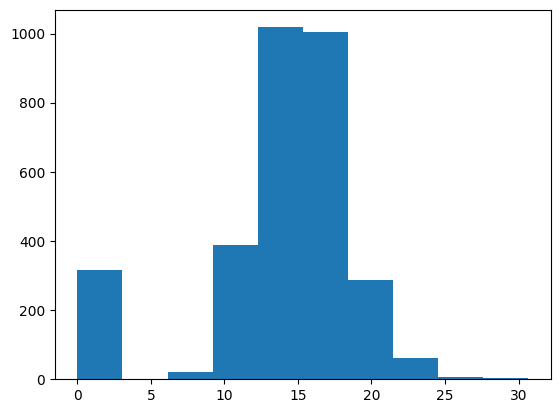

In [9]:
plt.hist( np.log( gdfjoined2['totalAssist'] + 1)  )

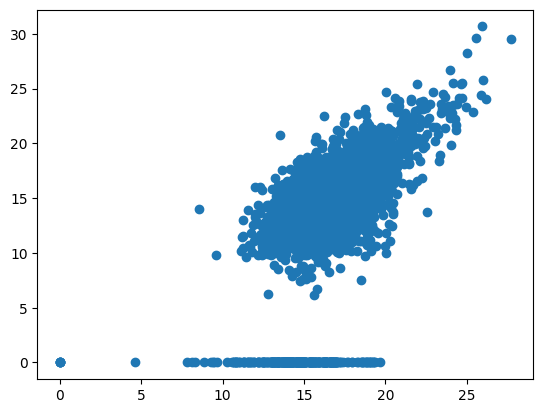

In [10]:
plt.scatter( np.log(gdfjoined2['totalDamage']+1),  np.log(gdfjoined2['totalAssist']+1) )

In [11]:
gdfjoined2['totalDamage2']  = np.log( gdfjoined2['totalDamage'] +1)
gdfjoined2['totalAssist2']  = np.log( gdfjoined2['totalAssist'] +1)
gdfjoined2['DamageSOVI2']   = np.log( gdfjoined2['DamageSOVI'] )

In [12]:
y1 = gdfjoined2[ 'totalAssist2' ].values
w1 = Queen.from_dataframe( gdfjoined2 )
w1.transform = 'r'
x1 = (gdfjoined2['totalDamage2'] ).values
moran_loc_bv1 = Moran_Local_BV(x1, y1, w1)

print( len( moran_loc_bv1.q ) )
print(  moran_loc_bv1.p_sim )
print( moran_loc_bv1.permutations )

gdfjoined2['label1']    = moran_loc_bv1.q
gdfjoined2['x1']        = moran_loc_bv1.p_sim
gdfjoined2['p_sim1']    = moran_loc_bv1.p_sim
gdfjoined2['MoranI1']   = moran_loc_bv1.Is

color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2.loc[ gdfjoined2['x1'] >= 0.05 ,'label1'] = 0
gdfjoined2["color1"] = gdfjoined2["label1"].map( color_mapping )


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.
  warnings.warn(message)


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')
3108
[0.201 0.006 0.47  ... 0.007 0.025 0.144]
999


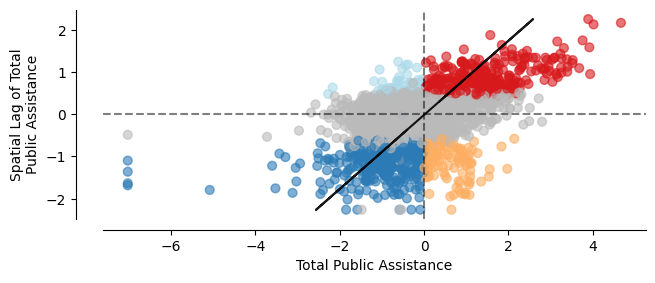

In [13]:
from splot.esda import plot_moran

fig, ax = moran_scatterplot( moran_loc_bv1 , p=0.05)
ax.set_xlabel('Total Public Assistance')
ax.set_ylabel('Spatial Lag of Total\nPublic Assistance')
ax.set_title('')

plt.show()

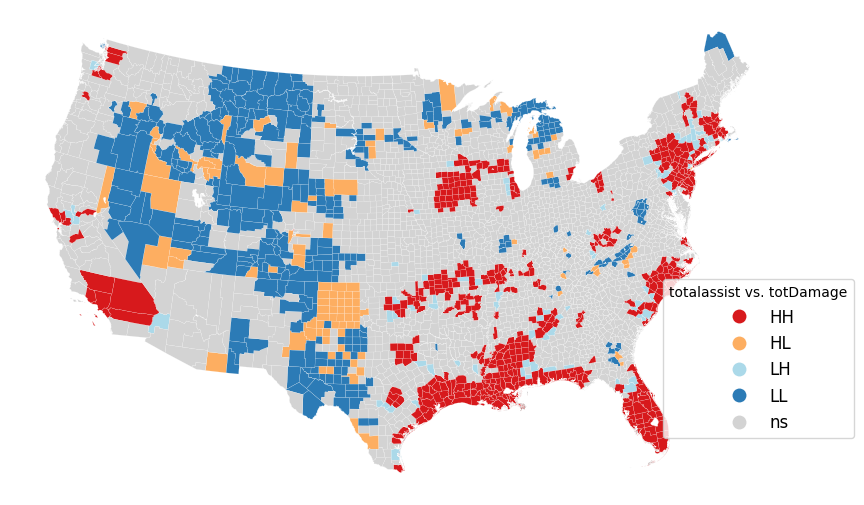

In [14]:
lisa_cluster(moran_loc_bv1, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  
                          'title': "totalassist vs. totDamage", 
                          'bbox_to_anchor': (1.1, 0.1),
                          'fontsize':'large' }, figsize=(10, 12), )
plt.show()


In [205]:
gdfjoined2.columns

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg',
       'CropDmg(AD', 'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2',
       'Injuries', 'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D',
       'PAprojectA', 'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount',
       'HAtotal', 'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'cbsa', 'totalAssist',
       'totalAssist3', 'totalDamage', 'DamageSOVI', 'totalDamage2',
       'totalAssist2', 'DamageSOVI2', 'label1', 'x1', 'p_sim1', 'MoranI1',
       'color1'],
      dtype='object')

In [15]:
y5 = ( gdfjoined2['totalAssist2'] ).values
x5 = gdfjoined2['SOVI_SCORE'].values 
moran_loc_bv5 = Moran_Local_BV(x5, y5, w1)

gdfjoined2['label2']    = moran_loc_bv5.q
gdfjoined2['x2']        = moran_loc_bv5.p_sim
gdfjoined2['p_sim2']    = moran_loc_bv5.p_sim
gdfjoined2['MoranI2']   = moran_loc_bv5.Is

color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined2.loc[ gdfjoined2['x2'] >= 0.05 ,'label2'] = 0
gdfjoined2["color2"] = gdfjoined2["label2"].map( color_mapping )


In [207]:
moran_loc_bv5.Is

array([ 0.02127215, -0.53136774,  0.32838272, ...,  0.52415832,
        0.30261512,  0.62604631])

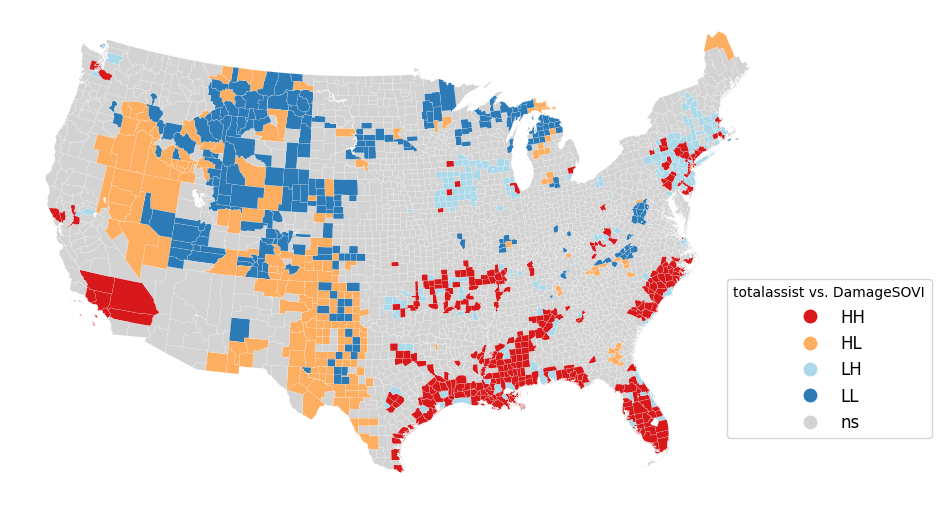

In [16]:
lisa_cluster(moran_loc_bv5, gdfjoined2, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. DamageSOVI", 
                            'bbox_to_anchor': (1.2, 0.1), 'fontsize':'large' },
                            figsize=(10, 12), )
plt.show()


<Axes: >

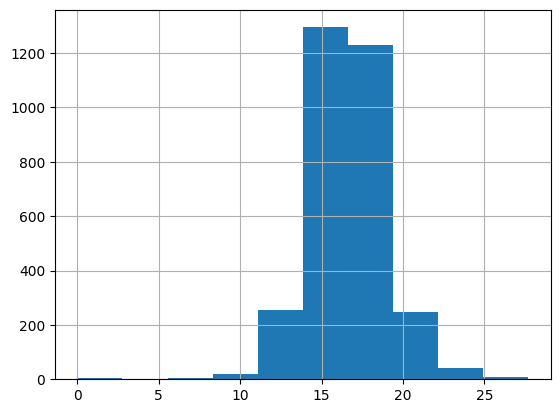

In [17]:
gdfjoined2["totalDamage2"].hist()

In [18]:
def percentile_rank(column):
   return column.rank(pct = True)

gdfjoinedx = gdfjoined2.loc[ (gdfjoined2["label1"]       > 0)& 
                            (gdfjoined2["totalDamage2"]  > 20) &
                             (gdfjoined2["POPULATION"]   > 1000000) ] 
gdfjoinedx['DamgPerRank'] = percentile_rank(gdfjoinedx['totalDamage2'] )
print( gdfjoinedx[['totalDamage2', 'DamgPerRank']].head() )
print( gdfjoinedx[ 'DamgPerRank'].max() )


     totalDamage2  DamgPerRank
175     22.377369     0.800000
189     20.466995     0.133333
192     21.335175     0.400000
296     21.915743     0.600000
318     22.292348     0.733333
1.0


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
import plotly.express as px
gdfjoinedx2 = gdfjoinedx.loc[ gdfjoinedx['cbsa'] != '0' ].groupby([ 'NAME', 'cbsa'], as_index=False).agg({  
    "POPULATION": ['sum'],
    "totalDamage": ['sum'],
    "totalAssist": ['sum'],
    "SOVI_SCORE": ['mean'],
    "MoranI1": ['mean'] })
gdfjoinedx2.columns = gdfjoinedx2.columns.droplevel(1)
gdfjoinedx2["logDamage"] = np.log( gdfjoinedx2["totalDamage"] +1)
gdfjoinedx2["logAssist"] = np.log( gdfjoinedx2["totalAssist"] +1)
gdfjoinedx2.head()

,NAME,cbsa,POPULATION,totalDamage,totalAssist,SOVI_SCORE,MoranI1,logDamage,logAssist
0,"Austin-Round Rock-Georgetown, TX",Austin-Round Rock-Georgetown,1285769,6.417870e+08,6.012891e+08,57.799999,1.214038,20.279767,20.214586
1,"Chicago-Naperville-Elgin, IL-IN-WI",Chicago-Naperville-Elgin,5272775,1.148120e+09,2.280008e+10,80.040001,1.115555,20.861392,23.850030
2,"Dallas-Fort Worth-Arlington, TX",Dallas-Fort Worth-Arlington,5777806,8.770719e+09,1.095567e+10,64.353333,1.657847,22.894685,23.117123
3,"Detroit-Warren-Dearborn, MI",Detroit-Warren-Dearborn,1792549,1.420756e+09,1.347059e+09,87.139999,1.548338,21.074455,21.021189
4,"Houston-The Woodlands-Sugar Land, TX",Houston-The Woodlands-Sugar Land,4726200,7.162522e+10,1.886520e+12,89.529999,5.201688,24.994713,28.265755


In [20]:
fig = px.scatter( gdfjoinedx2, x="logDamage", y="MoranI1",
	            size="POPULATION", color="cbsa", text="cbsa",
                hover_name="cbsa", log_x=True, size_max=60)
fig.show()

In [21]:
fig = px.bar( gdfjoinedx2, x='continent', y='pop', color="lifeExp", text='country', 
             title="Default behavior: some text is tiny")
fig.update_traces(textposition='inside')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['NAME', 'cbsa', 'POPULATION', 'totalDamage', 'totalAssist', 'SOVI_SCORE', 'MoranI1', 'logDamage', 'logAssist'] but received: continent

In [ ]:
gdfjoined2.columns

In [22]:
gdfjoined2 = gpd.GeoDataFrame( gdfjoined2, geometry = 'geometry', crs="EPSG:2163")
gdfjoined2.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_all.shp")

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_5395/3962461224.py:2: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



In [23]:
gdfjoined3 = gpd.read_file( r"exported_data/states_sheldus_declared.shp")
gdfjoined3 = gdfjoined3.to_crs({'init':'epsg:2163'})

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [24]:
gdfjoined3['totalAssist'] = gdfjoined3['HMAprojAmo']  + gdfjoined3['PAprojectA'] + gdfjoined3['PDMprojAmo'] + gdfjoined3['HAtotal'] + gdfjoined3['SBAapprove'] 
gdfjoined3['totalAssis2'] = gdfjoined3['HMAprojAmo']  + gdfjoined3['PAprojectA'] + gdfjoined3['PDMprojAmo'] + gdfjoined3['HAtotal']

gdfjoined3['totalDamage'] = gdfjoined3['CropDmg'] + gdfjoined3['PropertyDm'] 
gdfjoined3['DamageSOVI']  = gdfjoined3['HazardCoun'] * gdfjoined3['SOVI_SCORE'] 

In [25]:
gdfjoined3['totalDamage2']  = np.log( gdfjoined3['totalDamage'] +1)
gdfjoined3['totalAssist2']  = np.log( gdfjoined3['totalAssist'] +1)
gdfjoined3['DamageSOVI2']   = np.log( gdfjoined3['DamageSOVI'] )


In [26]:
print( gdfjoined3.columns )
new_splited_col         = gdfjoined3["NAME"].str.split(",", n = 1, expand = True)
gdfjoined3["cbsa"]     = new_splited_col[0]

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'NumPropert', 'CropDmg', 'CropDmg21',
       'CropDmgPer', 'PropertyDm', 'ProDmg21', 'ProDmgPerC', 'Injuries',
       'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D', 'PAprojectA',
       'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount', 'HAtotal',
       'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'totalAssist', 'totalAssis2',
       'totalDamage', 'DamageSOVI', 'totalDamage2', 'totalAssist2',
       'DamageSOVI2'],
      dtype='object')


In [27]:
y11 = ( gdfjoined3['totalAssist2'] ).values
w11 = Queen.from_dataframe( gdfjoined3 )
w11.transform = 'r'
x11 = gdfjoined3['totalDamage2'].values 
moran_loc_bv11 = Moran_Local_BV(x11, y11, w11)

gdfjoined3['label1'] = moran_loc_bv11.q
gdfjoined3['x1']          = moran_loc_bv11.p_sim
gdfjoined3['p_sim1'] = moran_loc_bv11.p_sim
gdfjoined3['MoranI1']   = moran_loc_bv11.Is

color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined3.loc[ gdfjoined3['x1'] >= 0.05 ,'label1'] = 0
gdfjoined3["color1"] = gdfjoined3["label1"].map( color_mapping )


('WARNING: ', 1186, ' is an island (no neighbors)')
('WARNING: ', 1192, ' is an island (no neighbors)')
('WARNING: ', 1836, ' is an island (no neighbors)')
('WARNING: ', 2946, ' is an island (no neighbors)')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: 1186, 1192, 1836, 2946.



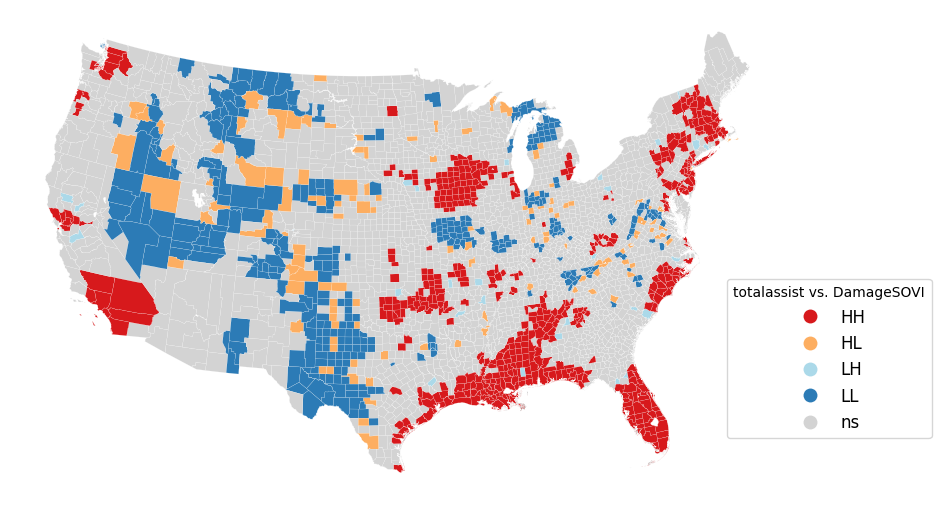

In [28]:
lisa_cluster(moran_loc_bv11, gdfjoined3, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. DamageSOVI", 
                           'bbox_to_anchor': (1.2, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [29]:
y12 = ( gdfjoined3['totalAssist2'] ).values
#w12 = Queen.from_dataframe( gdfjoined3 )

#w12.transform   = 'r'
x12             = gdfjoined3['SOVI_SCORE'].values 
moran_loc_bv12  = Moran_Local_BV( x12, y12, w11)
print( np.unique( moran_loc_bv12.q ) )

gdfjoined3['label2']    = moran_loc_bv12.q
gdfjoined3['x2']        = moran_loc_bv12.p_sim
gdfjoined3['p_sim2']    = moran_loc_bv12.p_sim
gdfjoined3['MoranI2']   = moran_loc_bv12.Is

color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined3.loc[ gdfjoined3['x2'] >= 0.05 ,'label2'] = 0
gdfjoined3["color2"] = gdfjoined3["label2"].map( color_mapping )


[1 2 3 4]


<Axes: >

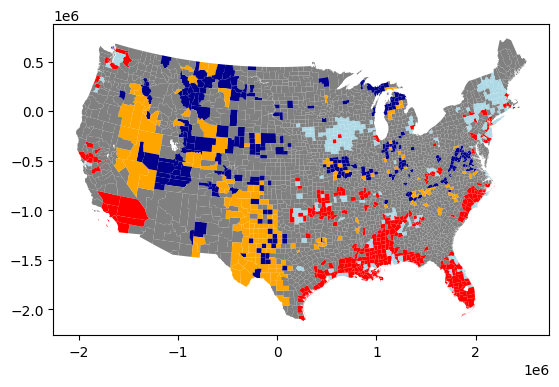

In [30]:
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
color_mapping = { 0: "grey", 1: "red", 2: "lightblue", 3: "darkblue", 4: "orange"  }
gdfjoined3.plot( color= gdfjoined3["label2"].map( color_mapping ) )

In [31]:
print( gdfjoined3["label2"].map( color_mapping ).head() )
print( gdfjoined3["label1"].head() )
print( gdfjoined3["x1"].head() )

0         grey
1    lightblue
2         grey
3          red
4          red
Name: label2, dtype: object
0    0
1    1
2    0
3    1
4    1
Name: label1, dtype: int64
0    0.247
1    0.002
2    0.271
3    0.010
4    0.004
Name: x1, dtype: float64


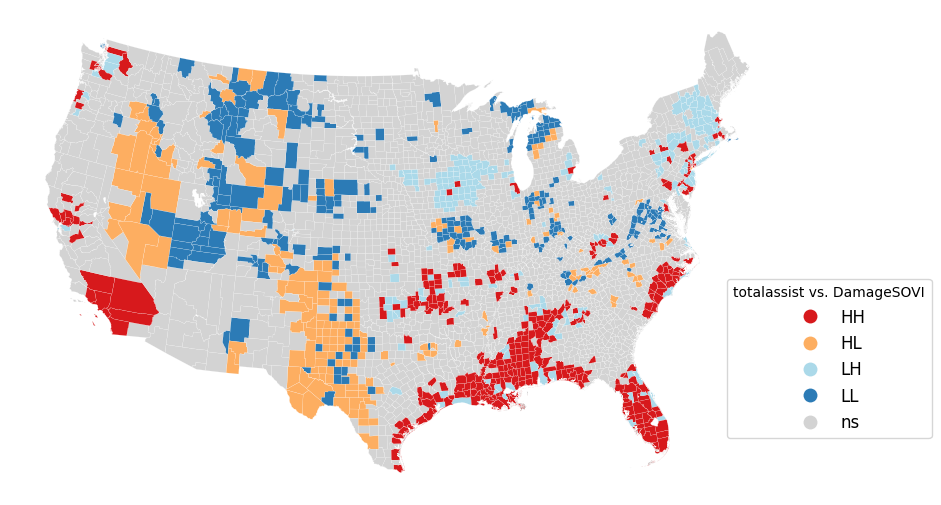

In [32]:
lisa_cluster(moran_loc_bv12, gdfjoined3, p=0.05, 
             legend_kwds={'loc': 'lower right',  'title': "totalassist vs. DamageSOVI", 
                           'bbox_to_anchor': (1.2, 0.1), 'fontsize':'large' }, figsize=(10, 12), )
plt.show()

In [262]:
gdfjoined3.columns

Index(['STATE', 'STATEABBRV', 'COUNTY', 'COUNTYFIPS', 'STCOFIPS', 'POPULATION',
       'BUILDVALUE', 'AGRIVALUE', 'SOVI_SCORE', 'RESL_VALUE', 'NAME', 'fips',
       'index', 'HMAprojAmo', 'AdminCostA', 'NumfinalPr', 'CropDmg',
       'CropDmg(AD', 'CropDmgPer', 'PropertyDm', 'Property_1', 'Property_2',
       'Injuries', 'InjuriesPe', 'Fatalities', 'Fataliti_1', 'Duration_D',
       'PAprojectA', 'PDMprojAmo', 'PDMcount', 'PDMNumfina', 'HMAcount',
       'HAtotal', 'HAcount', 'PAcount', 'SBAcount', 'SBAProjcou', 'SBAapprove',
       'HazardCoun', 'x', 'y', 'geometry', 'totalAssist', 'totalAssis2',
       'totalDamage', 'DamageSOVI', 'totalDamage2', 'totalAssist2',
       'DamageSOVI2', 'label1', 'x1', 'p_sim1', 'MoranI1', 'color1', 'cbsa',
       'label2', 'x2', 'p_sim2', 'MoranI2', 'color2'],
      dtype='object')

In [33]:
gdfjoined3 = gpd.GeoDataFrame( gdfjoined3, geometry = 'geometry', crs="EPSG:2163")
gdfjoined3.to_file(r"/Users/yuhan/Desktop/paper——revision/export_results/df_localMoran_declared.shp")

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_5395/2861641183.py:2: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



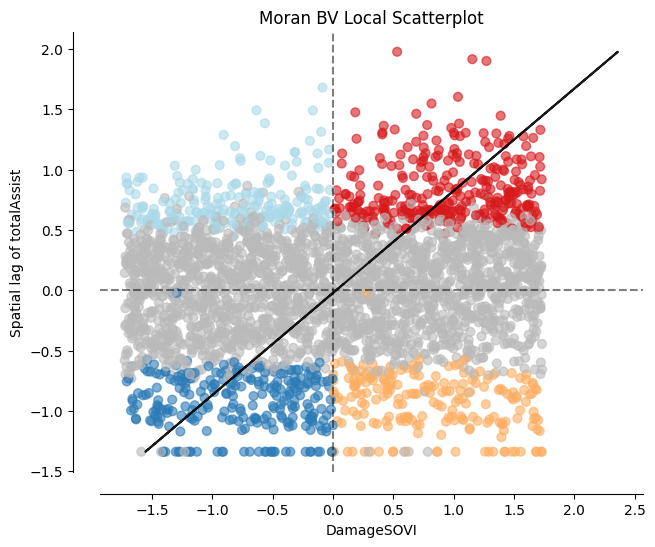

In [34]:
fig, ax = moran_scatterplot(moran_loc_bv12, p=0.05)
ax.set_xlabel('DamageSOVI')
ax.set_ylabel('Spatial lag of totalAssist')
plt.show()

In [174]:
np.unique( moran_loc_bv12.p_sim )

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
       0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
       0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
       0.127, 0.128,

In [175]:
np.unique( moran_loc_bv12.q )

array([1, 2, 3, 4])